In [1]:
import math
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import cv2
plt.rcParams['image.cmap'] = 'gray'

import funtions from scripts

In [2]:
import os
os.chdir('saliency_model/')

In [3]:
from utils import *

Load the images

In [4]:
img = mpimg.imread('../imgs/balloons.png')
# img2 = cv2.imread('../imgs/balloons.png')

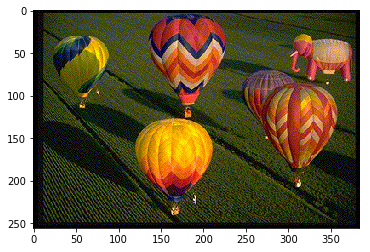

In [5]:
plt.imshow(img);

convert to double if image is uint8

In [6]:
rf = receptive_field_matrix(lambda x, y: mexican_hat(x, y, 2, 3))

In [7]:
img_hat = signal.convolve(img[:,:,0], rf, mode='same')

sum together maps across channels

In [8]:
img.shape

(256, 384, 3)

In [9]:
img[:, :, 0].shape

(256, 384)

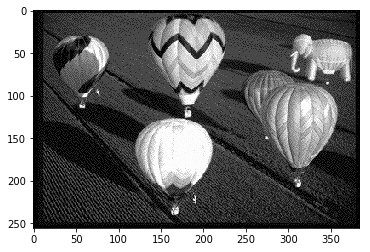

In [10]:
plt.imshow(img[:,:,0]);

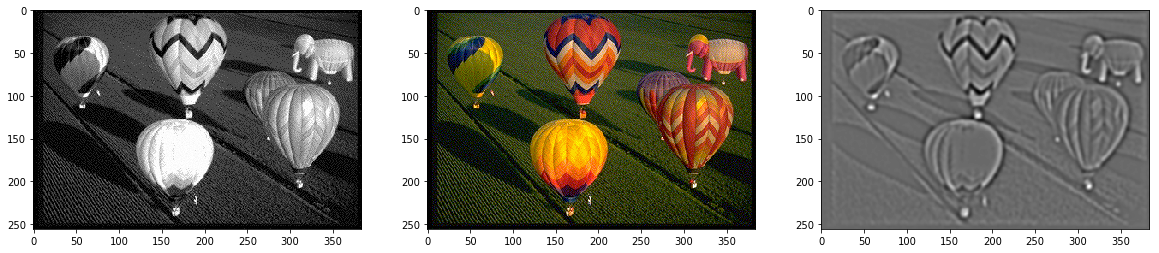

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img[:,:,0])
ax[1].imshow(img)
ax[2].imshow(img_hat);

---

## Determine the size and the number of center scales:  
First we scale the image to different sizes, so it has different resolutions we can work with.

In [12]:
mapwidth = 64
mapheight = round(img.shape[0] * (mapwidth / img.shape[1]))
scalars = [1, 2, 3]

img_list = downsample_image(img, mapheight, mapwidth, scalars)

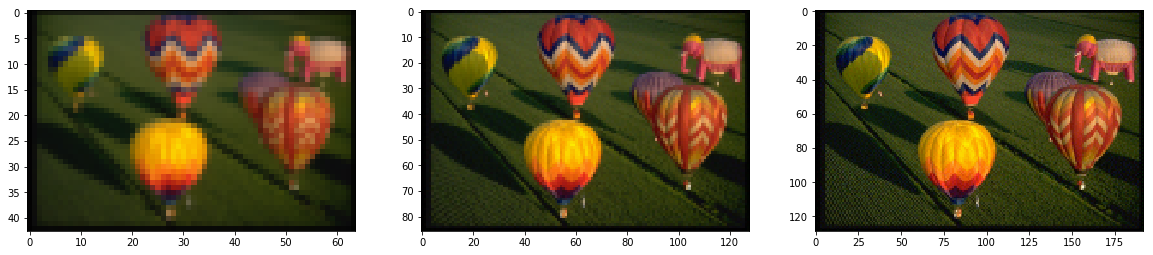

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_list[0])
ax[1].imshow(img_list[1])
ax[2].imshow(img_list[2]);

---

## split to channels & compute salience in each

### Compute intensity

In [14]:
from skimage.morphology import disk
from skimage.filters.rank import mean

In [15]:
img_avg = mean(img_hat, disk(5));

/home/ateska/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


#### depending on the set value into disk, we pick a different filert size

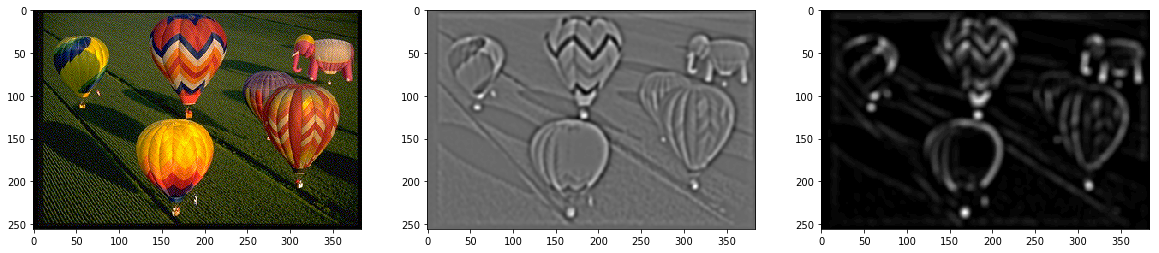

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img)
ax[1].imshow(img_hat);
ax[2].imshow(img_avg);

### Compute color channels

In [17]:
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

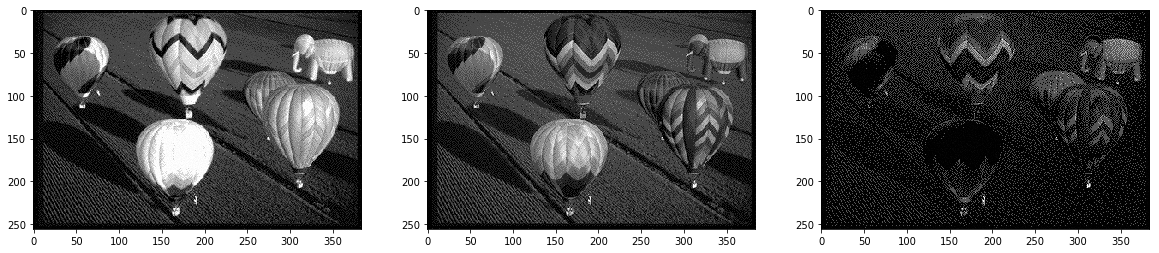

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(r)
ax[1].imshow(g)
ax[2].imshow(b);

#### RG and BY channels computations

In [19]:
by = np.divide((b - np.minimum(r,g)), np.maximum(np.maximum(r,g),b)) # (B-Y)
by_no_nan = np.nan_to_num(by)

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [20]:
rg = ((r - g) /np.maximum(np.maximum(r,g),b)); # (R-G)
rg_no_nan = np.nan_to_num(rg)

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


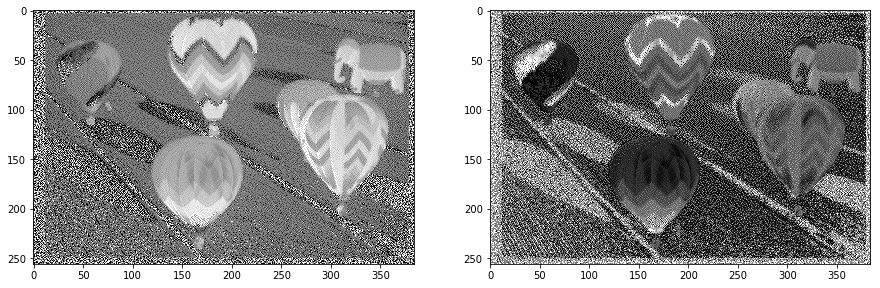

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(rg)
ax[1].imshow(by);

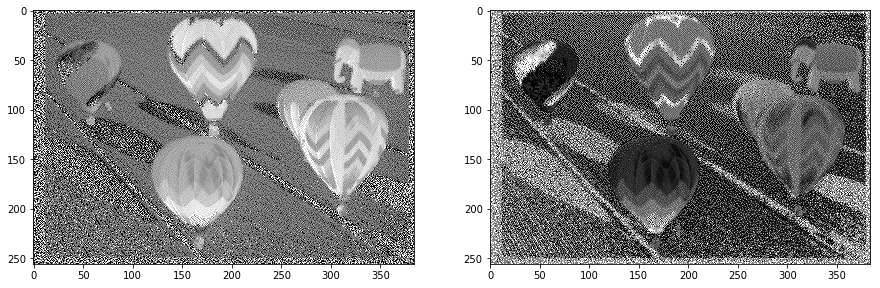

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(rg_no_nan)
ax[1].imshow(by_no_nan);

### Orientation filter

In [23]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from scipy import ndimage as nd

In [49]:
# single filter definition
theta = 1
theta = theta / 4. * np.pi
sigma = 4
frequency = 0.5

kernel = np.real(gabor_kernel(frequency, theta=theta,
                              sigma_x=sigma, sigma_y=sigma))

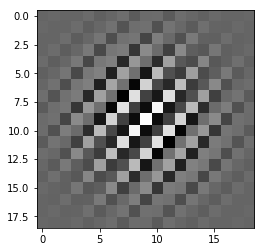

In [50]:
plt.imshow(kernel);

In [111]:
# multiple filters definition
kernels = []
phase = [0, 90]
sigma = 4
theta = 4
frequency = 0.15

# for ph in phase:
for theta in range(int(theta)):
    theta = theta / 4. * np.pi
    kernel = np.real(gabor_kernel(frequency, theta=theta,
                                  sigma_x=sigma, sigma_y=sigma,
                                  offset=0))
    kernels.append(kernel)

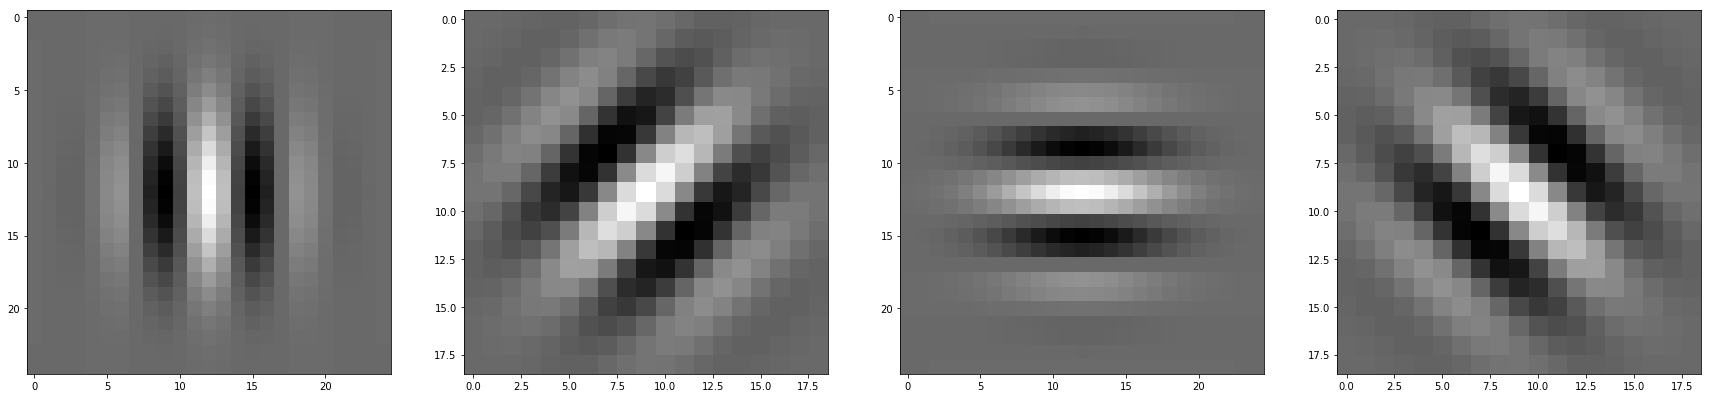

In [112]:
j = len(kernels)

fig, ax = plt.subplots(1, j, figsize=(30, 30))
for i in range(j):
    ax[i].imshow(kernels[i])

In [107]:
def compute_feats(image, kernels):
    '''compute features for multiple kernels'''
    feats = np.zeros_like(image)
    
    for kernel in kernels:
        filtered = nd.convolve(image, kernel)
        feats = feats + filtered

    feats = feats / len(kernels)  # normalize
    
    return feats 


In [95]:
# f0 = myconv2(img(:,:,fr),param.gabor{angi}.g0);
# f90 = myconv2(img(:,:,fr),param.gabor{angi}.g90);
# map(:,:,fr) = attenuateBorders( abs(f0) + abs(f90) , 13 );

# filter.g0 = gaborFilter(angle,0);
# filter.g90 = gaborFilter(angle,90);

In [96]:
orient  = np.zeros_like(img_list[2][:,:,0])
orient0 = np.zeros_like(img_list[0][:,:,0])
orient1 = np.zeros_like(img_list[1][:,:,0])
orient2 = np.zeros_like(img_list[2][:,:,0])

for i in range(3):
    orient0 = orient0 + compute_feats(img_list[0][:,:,i], kernels)
    
for i in range(3):
    orient1 = orient1 + compute_feats(img_list[1][:,:,i], kernels)

for i in range(3):
    orient2 = orient2 + compute_feats(img_list[2][:,:,i], kernels)

### Resize the images to sum them up

In [97]:
mapsize = [ round(np.size(img,0) / np.size(img,1) * mapwidth), mapwidth ];
mapsize
# chanmap = chanmap + wj * imresize(maps{ci}{cj}, mapSize );

[43, 64]

In [98]:
from skimage.transform import resize

In [115]:
orient0_new = resize(orient0, mapsize, mode='constant')
orient1_new = resize(orient1, mapsize, mode='constant')
orient2_new = resize(orient2, mapsize, mode='constant')

/home/ateska/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [116]:
eps = 1e-2

orient = orient0_new + orient1_new + orient2_new
orient[abs(orient) < eps] = 0

orient;

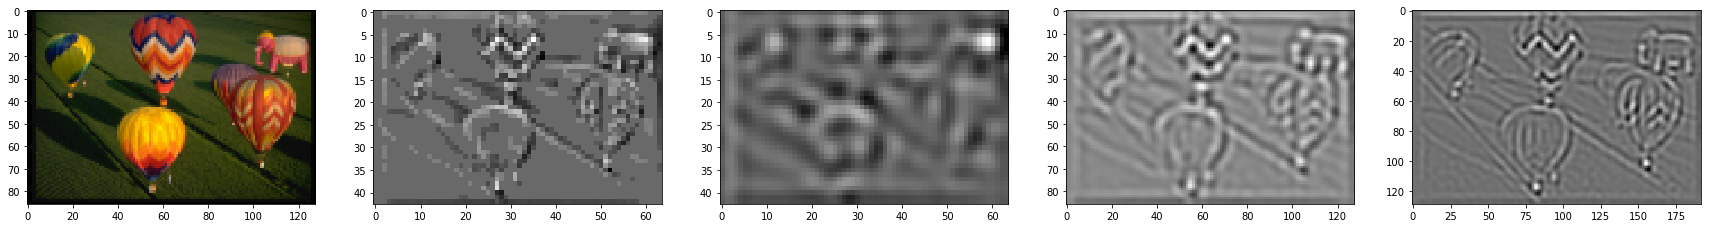

In [117]:
fig, ax = plt.subplots(1, 5, figsize=(30, 30))
ax[0].imshow(img_list[1])
ax[1].imshow(orient);
ax[2].imshow(orient0);
ax[3].imshow(orient1);
ax[4].imshow(orient2);

In [84]:
# orient_interp = np.interp(orient, (orient.min(), orient.max()), (0, 1))
# # np.interp(a, (a.min(), a.max()), (-1, +1))

# fig, ax = plt.subplots(1, 3, figsize=(15, 15))
# ax[0].imshow(img_list[1])
# ax[1].imshow(orient);
# ax[2].imshow(orient_interp);

### Color Bias

In [36]:
from skimage.color import rgb2hsv

In [37]:
img_hsv = rgb2hsv(img)

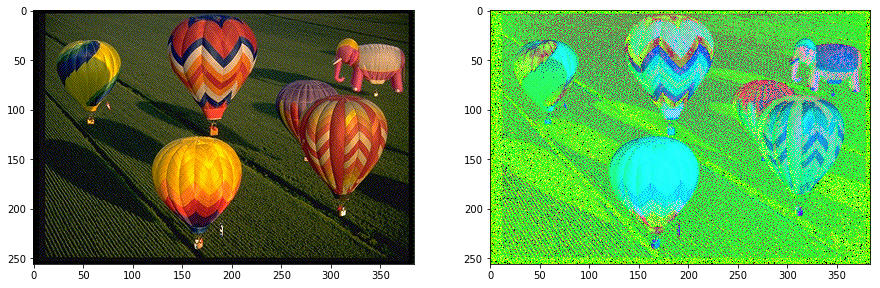

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img)
ax[1].imshow(img_hsv);

----

## apply center surround